In [1]:
import os, sys, glob
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [440]:
def color(index, alpha=1):
    color_list = ['#5374a2', '#a0a0a0', '#0c6374', '#c07a1b']
    return color_list[index % len(color_list)] + hex(int(255*alpha))[2:]

def progress_bar(current_value, max_value, size=50):
    prog = (current_value+1)/max_value
    left = '#'*int(prog * size + 0.5) # 0.5 to round up when casting to int
    right = '-'*(size-len(left))
    print('\r[{}{}] {:.1f}%'.format(left, right, prog*100), end='')

def quadratic_kappa(actuals, preds, N=5):
    """This function calculates the Quadratic Kappa Metric used for Evaluation in the PetFinder competition
    at Kaggle. It returns the Quadratic Weighted Kappa metric score between the actual and the predicted values 
    of adoption rating."""
    w = np.zeros((N,N))
    O = confusion_matrix(actuals, preds)
    for i in range(len(w)): 
        for j in range(len(w)):
            w[i][j] = float(((i-j)**2)/(N-1)**2)
    
    act_hist=np.zeros([N])
    for item in actuals: 
        act_hist[item]+=1
    
    pred_hist=np.zeros([N])
    for item in preds: 
        pred_hist[item]+=1
                         
    E = np.outer(act_hist, pred_hist);
    E = E/E.sum();
    O = O/O.sum();
    
    num=0
    den=0
    for i in range(len(w)):
        for j in range(len(w)):
            num+=w[i][j]*O[i][j]
            den+=w[i][j]*E[i][j]
    return (1 - (num/den))

In [441]:
ROOT_PATH = '..'
df = pd.read_csv(f'{ROOT_PATH}/data/train.csv')
import pickle
with open(f'{ROOT_PATH}/score_pca_components.pkl', 'rb') as f:
    res = pickle.load(f)

Text(0, 0.5, 'Score')

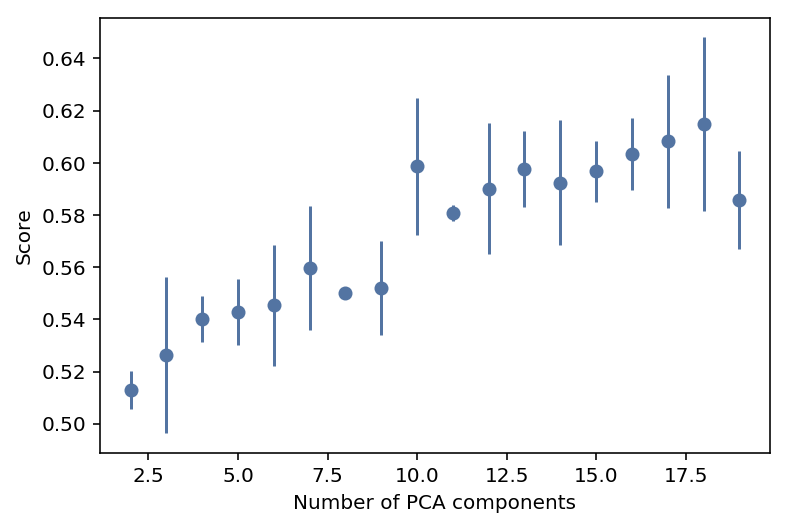

In [442]:
df_score = pd.DataFrame(res, index=None, columns=['pca_components', 'score'])
scores_mean = df_score.groupby('pca_components').mean()
scores_std = df_score.groupby('pca_components').std()
pca_components = scores_std.index.values

plt.errorbar(pca_components, scores_mean.values, scores_std.values, fmt='o', color=color(0))
plt.xlabel('Number of PCA components')
plt.ylabel('Score')

## Feature generation

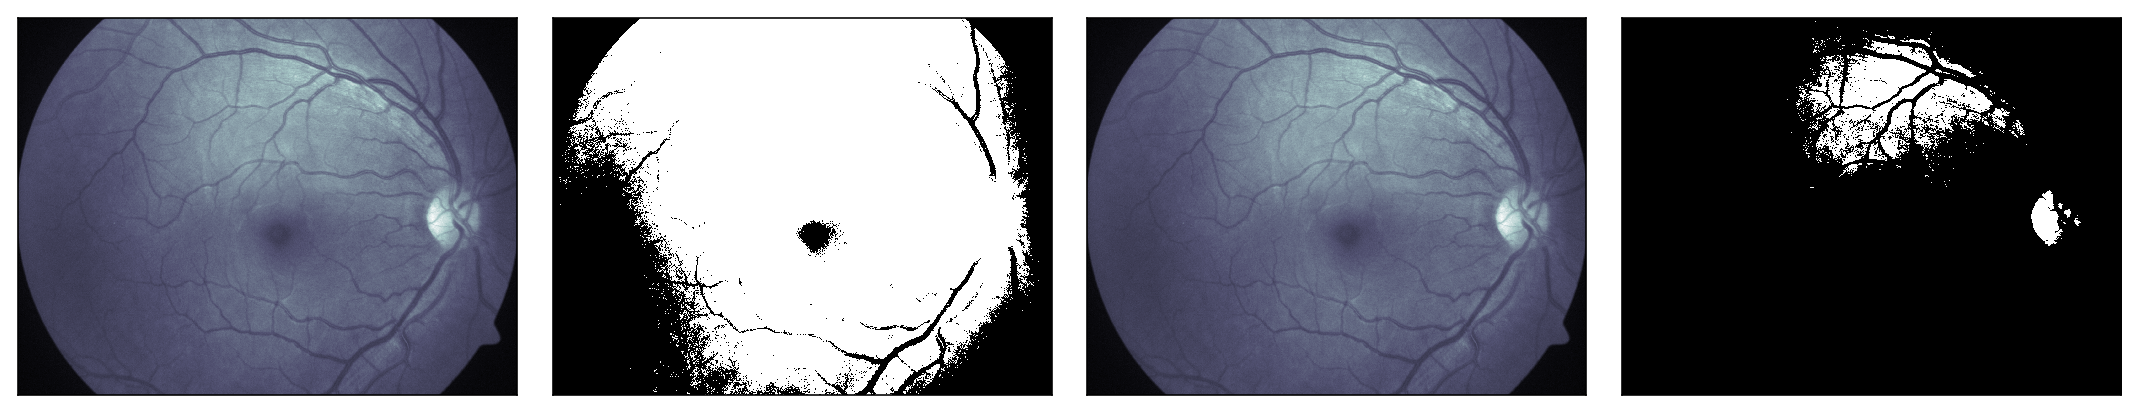

In [9]:
import cv2

image_index = 6
image_path = f'{ROOT_PATH}/data/train_images/{df.id_code[image_index]}.png'
img = cv2.imread(image_path)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,4))
cmap = 'bone'

img = img.mean(2)
img = img - np.mean(img)
img = img/np.std(img)
ax1.imshow(img, cmap=cmap)

inside_region  = img > -0.3
ax2.imshow(inside_region, cmap=cmap)

img = img - np.mean(img[inside_region])
img = img / np.std(img[inside_region])
ax3.imshow(img, cmap=cmap)

binary_features = img > 1.5
ax4.imshow(binary_features, cmap=cmap)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set(**{'xticks':[], 'yticks':[]})
plt.tight_layout()

In [ ]:
def get_binary_image(img, inside_thresh=-0.3, feature_thresh=1):
    img = img.mean(2)
    img = img - np.mean(img)
    img = img/np.std(img)
    inside_region  = img > inside_thresh
    img = img - np.mean(img[inside_region])
    img = img / np.std(img[inside_region])
    binary_features = img > feature_thresh
    return binary_features

def get_momentums(binary_features):
    moments = cv2.moments(binary_features.astype(float))
    hu_moments_list = cv2.HuMoments(moments).flatten().tolist()
    moments_list = [moments[key] for key in sorted(moments.keys())]
    return moments_list + hu_moments_list


moments = cv2.moments(binary_features.astype(float))
hu_moments_list = cv2.HuMoments(moments).flatten().tolist()
moments_count = len(moments)
hu_moments_count = len(hu_moments_list)
print(moments_count, hu_moments_count)

### Time consuming feature generation

In [202]:
# df = pd.read_csv(f'{ROOT_PATH}/data/train.csv')
# for moment_index in range(moments_count+hu_moments_count):
#     df[f'a_{moment_index:02d}'] = np.nan
#     df[f'b_{moment_index:02d}'] = np.nan
#     df[f'c_{moment_index:02d}'] = np.nan
#     df[f'd_{moment_index:02d}'] = np.nan
#     df[f'e_{moment_index:02d}'] = np.nan

# BRIEF_DESCRIPTOR_LEN = 256
# for brief_descriptor_index in range(BRIEF_DESCRIPTOR_LEN):
#     df[f'brief_{brief_descriptor_index:03d}'] = np.nan
    
# for index, row in df.iterrows():
#     image_path = f'{ROOT_PATH}/data/train_images/{row.id_code}.png'
#     img = cv2.imread(image_path)
    
#     feature_extractor = cv2.xfeatures2d.StarDetector_create()
#     keyPoints = feature_extractor.detect(img)
#     brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
#     _, descriptors = brief.compute(img, keyPoints)
#     for descriptor_index in range(BRIEF_DESCRIPTOR_LEN):
#         try:
#             df.loc[index, f'brief_{descriptor_index:03d}'] = descriptors.flatten()[descriptor_index]
#         except:
#             pass
    
#     for feature_thresh, letter in zip([0.8, 1, 1.2, 1.4, 1.6], ['a','b','c','d','e']):
#         binary_features = get_binary_image(img, inside_thresh=-0.3, feature_thresh=feature_thresh)
#         momentums = get_momentums(binary_features)
#         for momentum_index, momentum in enumerate(momentums):
#             df.loc[index, f'{letter}_{momentum_index:02d}'] = momentum
        
#     progress_bar(index, df.shape[0])

[##################################################] 100.0%

In [203]:
# df.to_csv(f'{ROOT_PATH}/data/train_big_feature.csv')

In [206]:
# df_test = pd.read_csv(f'{ROOT_PATH}/data/test.csv')
# for moment_index in range(moments_count+hu_moments_count):
#     df_test[f'a_{moment_index:02d}'] = np.nan
#     df_test[f'b_{moment_index:02d}'] = np.nan
#     df_test[f'c_{moment_index:02d}'] = np.nan
#     df_test[f'd_{moment_index:02d}'] = np.nan
#     df_test[f'e_{moment_index:02d}'] = np.nan

# BRIEF_DESCRIPTOR_LEN = 256
# for brief_descriptor_index in range(BRIEF_DESCRIPTOR_LEN):
#     df_test[f'brief_{brief_descriptor_index:03d}'] = np.nan
    
# for index, row in df_test.iterrows():
#     image_path = f'{ROOT_PATH}/data/test_images/{row.id_code}.png'
#     img = cv2.imread(image_path)
    
#     feature_extractor = cv2.xfeatures2d.StarDetector_create()
#     keyPoints = feature_extractor.detect(img)
#     brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
#     _, descriptors = brief.compute(img, keyPoints)
#     for descriptor_index in range(BRIEF_DESCRIPTOR_LEN):
#         try:
#             df_test.loc[index, f'brief_{descriptor_index:03d}'] = descriptors.flatten()[descriptor_index]
#         except:
#             pass
    
#     for feature_thresh, letter in zip([0.8, 1, 1.2, 1.4, 1.6], ['a','b','c','d','e']):
#         binary_features = get_binary_image(img, inside_thresh=-0.3, feature_thresh=feature_thresh)
#         momentums = get_momentums(binary_features)
#         for momentum_index, momentum in enumerate(momentums):
#             df_test.loc[index, f'{letter}_{momentum_index:02d}'] = momentum
        
#     progress_bar(index, df_test.shape[0])
    
# df_test.to_csv(f'{ROOT_PATH}/data/test_big_feature.csv')

(3662, 413)

## Generating the baseline

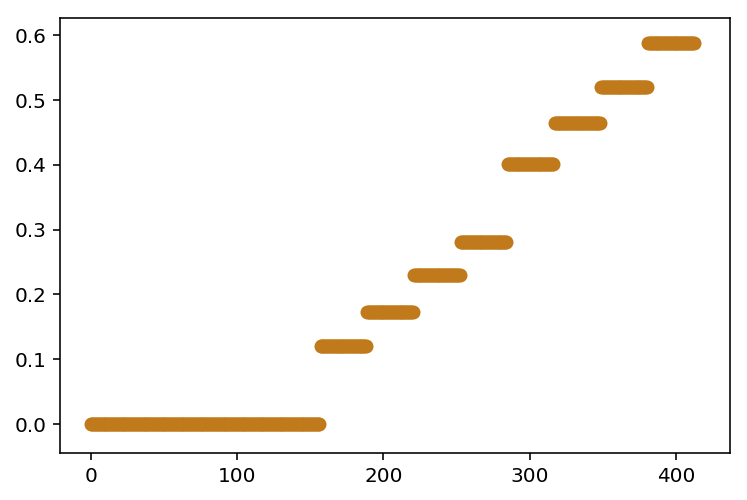

In [257]:
df_train = pd.read_csv(f'{ROOT_PATH}/data/train_big_feature.csv', index_col=0)
for i in range(413):
    plt.scatter(i, df_train[df_train.columns[i]].isna().sum()/df_train.shape[0], color=color(3))

In [332]:
## Cutting last columns, containing too many NaNs
df_train = pd.read_csv(f'{ROOT_PATH}/data/train_big_feature.csv', index_col=0).iloc[:,:220]
df_train = df_train.fillna(df_train.median())

In [363]:
from sklearn.preprocessing import Normalizer

y = df_train.diagnosis.values
df_X = df_train.drop(['id_code', 'diagnosis'], axis=1)
X = df_X.values
# y = (y>0)*1

# transformer = Normalizer().fit(X)
# transformer.transform(X)
# X = transformer.transform(X)
X = X - np.mean(X, 0)
X = X/np.std(X, 0)

In [368]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
print(f'Mean test: {y_test.mean()}\nMean train: {y_train.mean()}')

Mean test: 1.1487039563437926
Mean train: 1.1215431888016387


In [372]:
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.scorer import make_scorer
import copy

quadratic_kappa_score = make_scorer(quadratic_kappa, greater_is_better=True)

def run_xgb(X, y):
    gbm_param_grid = {
        'n_estimators': range(6, 26),
        'max_depth': range(4, 14),
        'learning_rate': np.linspace(0.1, 1.2, 30),
        'colsample_bytree': np.linspace(0.4, 1, 20)
    }

    gbm = XGBClassifier(n_estimators=10)
    xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                        estimator = gbm, scoring=quadratic_kappa_score, 
                                        verbose = 0, n_iter = 50, cv = 4)
    xgb_random.fit(X, y)

    gbm = XGBClassifier(n_estimators=10)
    gbm.set_params(**xgb_random.best_params_)
    gbm.fit(X, y)
    return gbm

In [397]:
best_model = {'score':0, 'model':None, 'pca_transform':None}

# def balance_data(X, y):
#     X_pos = X[y==0]
#     X_anomaly = X[y==1]
#     X_balanced = np.concatenate([X_pos[:X_anomaly.shape[0], :], X_anomaly], axis=0)
#     y_balanced = np.ones(X_balanced.shape[0])
#     y_balanced[:X_anomaly.shape[0]] = 0    
#     return X_balanced, y_balanced

def run_test(n_components, X_train, y_train, X_test, y_test, enable_pca=True):
    X, _, y, _ = train_test_split(X_train, y_train, test_size=0.05)    
    if enable_pca:
        pca = PCA(n_components=n_components)
        pca_transform = pca.fit(X)
    else:
        pca_transform = lambda :_
        pca_transform.transform = lambda x:x
        
    X = pca_transform.transform(X)
    X_test = pca_transform.transform(X_test)
#     X_balanced, y_balanced = balance_data(X, y)
    xgb = run_xgb(X, y)
    
    y_prediction = xgb.predict(X_test)
    score = quadratic_kappa(y_test, y_prediction, N=5)
    
    if score > best_model['score']:
        best_model['model'] = copy.deepcopy(xgb)
        best_model['score'] = score
        best_model['pca_transform'] = copy.deepcopy(pca_transform)
        
    return n_components, score

In [376]:
xgb = run_xgb(X_train, y_train)
cm = confusion_matrix(y_test, xgb.predict(X_test))

In [382]:
qk = quadratic_kappa(y_test, xgb.predict(X_test), N=5)
print(f'Quadratic Kappa: {qk:.3f}')

Quadratic Kappa: 0.660


### PCA

In [378]:
# no_pca = run_test(2, X_train, y_train, X_test, y_test, enable_pca=False)

In [401]:
for i in tqdm(np.arange(2, 20)):
    for index in range(3):
        res.append(run_test(i, X_train, y_train, X_test, y_test))


100%|██████████| 18/18 [49:31<00:00, 242.42s/it]

In [395]:
# no_pca = run_test(2, X_train, y_train, X_test, y_test, enable_pca=False)

[Text(0, 0.5, 'Score'), Text(0.5, 0, 'Number of components')]

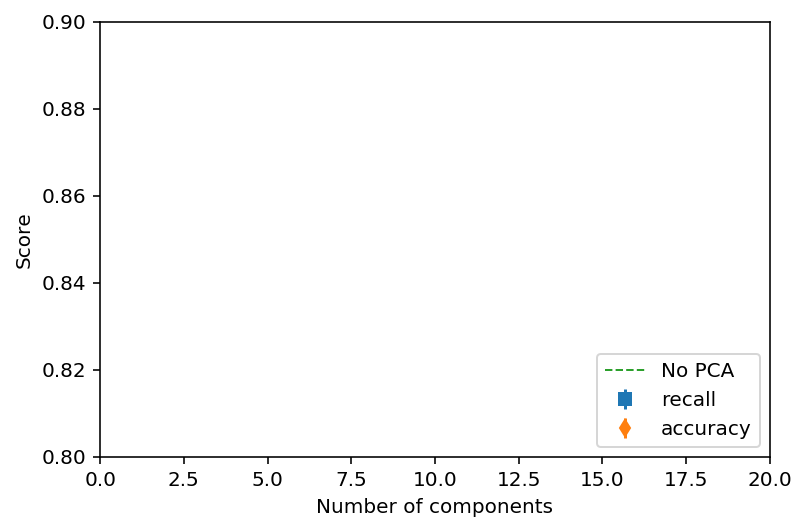

In [388]:
# res_array = np.array(res)
# df_results = pd.DataFrame(res_array)

# fig, ax = plt.subplots(1, figsize=(6, 4))
# n_estimators, recall_mean = df_results.groupby(0).std().index, df_results.groupby(0).mean()[2]
# n_estimators, recall_std = df_results.groupby(0).std().index, df_results.groupby(0).std()[2]
# ax.errorbar(n_estimators, recall_mean, recall_std ,fmt= 's', label='recall')


# n_estimators, accuracy_mean = df_results.groupby(0).std().index, df_results.groupby(0).mean()[1]
# n_estimators, accuracy_std = df_results.groupby(0).std().index, df_results.groupby(0).std()[1]
# ax.errorbar(n_estimators, accuracy_mean, accuracy_std ,fmt= 'd', label='accuracy')
# # plt.plot(res_array[:, 0], res_array[:, 1], 'd', alpha=0.2)
# ax.plot([0, 30], [qk, qk], '--', linewidth=1, label='No PCA')
# ax.set_ylim([0.8, 0.9])
# ax.set_xlim(0, 20)

# ax.legend(loc=4)
# ax.set(**{'xlabel':'Number of components', 'ylabel':'Score'})

# # fig.savefig('../plots/score_vs_components.png', bbox_inches='tight')

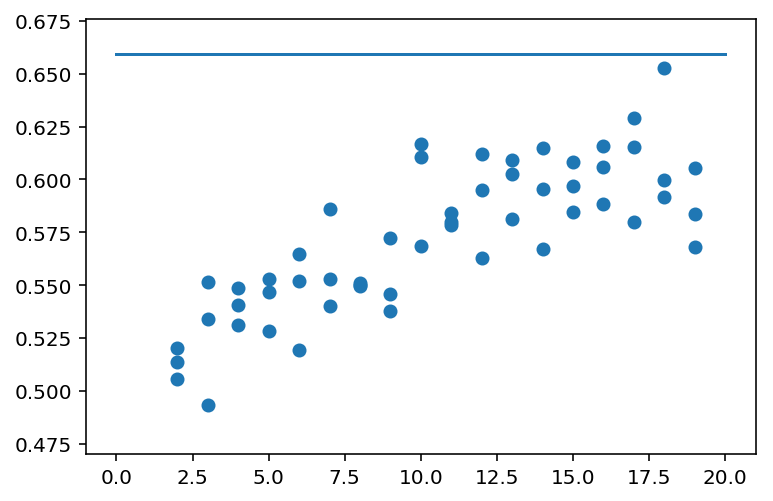

In [409]:
plt.scatter(*zip(*res))
plt.plot([0,20], [qk,qk])

In [412]:
# import pickle
# with open(f'{ROOT_PATH}/score_pca_components.pkl', 'wb') as f:
#     pickle.dump(res, f)